 # Softmax exercise

 *Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682-fa19.github.io/assignments2019/assignment1/) on the course website.*

 This exercise is analogous to the SVM exercise. You will:

 - implement a fully-vectorized **loss function** for the Softmax classifier
 - implement the fully-vectorized expression for its **analytic gradient**
 - **check your implementation** with numerical gradient
 - use a validation set to **tune the learning rate and regularization** strength
 - **optimize** the loss function with **SGD**
 - **visualize** the final learned weights


In [2]:
from __future__ import print_function
import random
import numpy as np
from cs682.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import itertools


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs682/datasets/cifar-10-batches-py'
    # Don't forget to run get_datasets.sh, or this will throw an error
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


 ## Softmax Classifier

 Your code for this section will all be written inside **cs682/classifiers/softmax.py**.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs682/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs682.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.358851
sanity check: 2.302585


 ## Inline Question 1:
 Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

 **Your answer:** Initially when weights are randomly assigned, all classes
 are equally likely to be predicted by the classifier. The model has not
 begun learning parameters and generalized the data. So the probability
 of a class getting predicted by the model is 1/10 = 0.1. As the model starts to
 learn parameters, it generalizes the data and adjusts the weights depending their
 presence in the dataset. So the probability of a class could increase or decrease.


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs682.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.933195 analytic: 0.933195, relative error: 1.135139e-08
numerical: -0.164618 analytic: -0.164618, relative error: 1.131511e-07
numerical: -0.726051 analytic: -0.726051, relative error: 2.307141e-08
numerical: -4.226875 analytic: -4.226875, relative error: 5.297797e-09
numerical: 0.091942 analytic: 0.091942, relative error: 1.011601e-07
numerical: -2.299650 analytic: -2.299650, relative error: 1.318220e-08
numerical: -1.985016 analytic: -1.985016, relative error: 4.508728e-08
numerical: -0.349872 analytic: -0.349872, relative error: 9.237913e-08
numerical: -0.318365 analytic: -0.318365, relative error: 2.389062e-07
numerical: -0.412830 analytic: -0.412830, relative error: 1.142612e-07
numerical: 3.250537 analytic: 3.250537, relative error: 7.408727e-09
numerical: 2.995079 analytic: 2.995079, relative error: 2.601999e-08
numerical: -0.100293 analytic: -0.100293, relative error: 4.512738e-07
numerical: -3.151161 analytic: -3.151161, relative error: 8.207694e-09
numerical: -4.

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs682.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.358851e+00 computed in 0.410119s
vectorized loss: 2.358851e+00 computed in 0.008605s
Loss difference: 0.000000
Gradient difference: 0.000000


In [11]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs682.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
best_combo=()
learning_rates = [1e-7, 2e-7, 3e-7, 4e-7, 5e-7, 1e-6, 2e-6, 3e-6, 4e-6, 5e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5]
regularization_strengths = [1e3, 2e3, 3e3, 4e3, 5e3, 1e4, 2e4, 2.5e4, 3e4, 3.5e4, 4e4, 4.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
combos = [(v[0], v[1]) for v in list(itertools.product(learning_rates, regularization_strengths))]
for combo in combos:
    print('\nEvaluating combo: ', combo)
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate=combo[0], reg=combo[1], num_iters=1500,
                        verbose=True)
    
    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)
    train_accuracy = np.mean(y_train == y_train_pred)
    val_accuracy = np.mean(y_val == y_val_pred)
    if best_val < val_accuracy:
        best_val = val_accuracy
        best_softmax  = softmax
        best_combo = combo
    results[combo] = (train_accuracy, val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print(f'\nbest validation accuracy achieved during cross-validation: {best_val} and the alpha, regularization that achieved it: {best_combo}')


Evaluating combo:  (1e-07, 1000.0)
iteration 0 / 1500: loss 36.481212
iteration 100 / 1500: loss 34.018574
iteration 200 / 1500: loss 32.394887
iteration 300 / 1500: loss 30.724795
iteration 400 / 1500: loss 29.632422
iteration 500 / 1500: loss 28.326805
iteration 600 / 1500: loss 27.422426
iteration 700 / 1500: loss 26.280433
iteration 800 / 1500: loss 24.993368
iteration 900 / 1500: loss 23.930709
iteration 1000 / 1500: loss 23.086741
iteration 1100 / 1500: loss 22.267685
iteration 1200 / 1500: loss 21.376493
iteration 1300 / 1500: loss 20.659859
iteration 1400 / 1500: loss 20.261635

Evaluating combo:  (1e-07, 2000.0)
iteration 0 / 1500: loss 66.683274
iteration 100 / 1500: loss 60.164602
iteration 200 / 1500: loss 55.060900
iteration 300 / 1500: loss 50.583058
iteration 400 / 1500: loss 46.768259
iteration 500 / 1500: loss 43.312425
iteration 600 / 1500: loss 40.017410
iteration 700 / 1500: loss 36.917123
iteration 800 / 1500: loss 34.005682
iteration 900 / 1500: loss 31.777506
it

In [12]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.377000


 **Inline Question** - *True or False*

 It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

 *Your answer*: True

 *Your explanation*: If the newly added data point has a large margin i.e the difference between scores of correct and incorrect class plus delta is less than 0, max function wil cap it at 0 in SVM loss.
 But that won't be the case for softmax as it involves taking exponents of the score. The resultant exponent will be small,but nonetheless would change the sotmax loss.



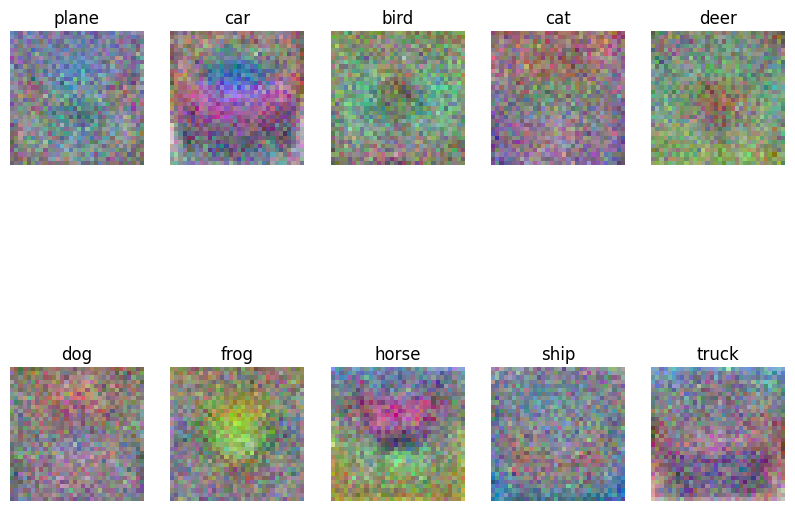

In [13]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])